In [6]:
import sys
import json
import numpy as np
from operator import add
from math import sqrt
# from pyspark import SparkContext
# sc = SparkContext(appName="ParseEventLog")
#from pyspark.sql import SQLContext
import copy
from parselogs import *
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from plot import SparkPlotter, RawValuesPlotter,Plotter, plot_hero
#import pandas

**Directories where logs are**

In [7]:

pca_log_dir = '/project/projectdirs/paralleldb/spark/benchmarks/pca_climate/large-scale-climate/eventLogs/'
nmf_log_dir = '/project/projectdirs/paralleldb/spark/benchmarks/nmf/nmfspark/eventLogs/'
cx_log_dir = '/project/projectdirs/paralleldb/spark/benchmarks/cx/event_logs/'

**Dictionary matching concurrency to log name**

In [8]:
pca_dic = {100: 'app-20160407025819-0000', 300: 'app-20160407032107-0000', 500:'app-20160407034211-0000', 1600: 'app-20160407050845-0000', 
           'oth': 'app-20160331051335-0000'}
pca_dict = {k: pca_log_dir + v for k,v in pca_dic.iteritems()} 
nmf_dic = {100: 'app-20160406163133-0000',50: 'app-20160406162858-0000', 300: 'app-20160406164522-0000' }
nmf_dict = {k: nmf_log_dir + v for k,v in nmf_dic.iteritems()}
cx_dic = {60:'app-20160307235013-0000', 100: 'app-20160331152132-0000', 300: 'app-20160310010018-0000'}
cx_dict = {k: cx_log_dir + v for k,v in cx_dic.iteritems()}
algo_name='PCA'

#Plot Summary Using Mean **TASK** in each Stage
* ie: Approximating the running time distribution by summing up the mean task in a stage

###NMF Plots

* SPARK

In [8]:
#stages to not count because we think there is double counting of IO
nmf_kill_stages = [0,1]

In [9]:
#mapping of stage to bucket name
nmf_s2p_name_dict = {'mapPartitionsWithIndex at Utils.scala': {2: "Parallel HDF5 Read", 'the_rest': 'Task Overhead Time'},
 'reduce at Utils.scala': 'Task Overhead Time',
 'zipWithIndex at read.scala': 'Parallel HDF5 Read'}

In [10]:
#match last driver time (ie the time after last spark stage) to the XRAY bucket
nmf_driver_comp_labels = {"XRAY": -1}

In [11]:
#Count this accumulable toward the TSQR bucket
accumulables = {'accum_name':"Time taken for Local QR", 'key_name':'TSQR'}

In [12]:
#get_stage_names(sc,nmf_dict[50])

In [13]:
#make the parse log objects for each run
keyed_nmf_pds = {k:ParseLogs(sc,nmf_dict[k] , 'nmf', nmf_s2p_name_dict, nmf_kill_stages, accumulables, nmf_driver_comp_labels) for k in [50,100,300]}

In [14]:
#make the plotter object

'''ALEX, here is where you can plug in your colors 
(should be list of strings in matplotlib readable format )'''
colors_list = colors.cnames.keys()[3:100]


pt_n = SparkPlotter(keyed_nmf_pds, colors_list=colors_list) 

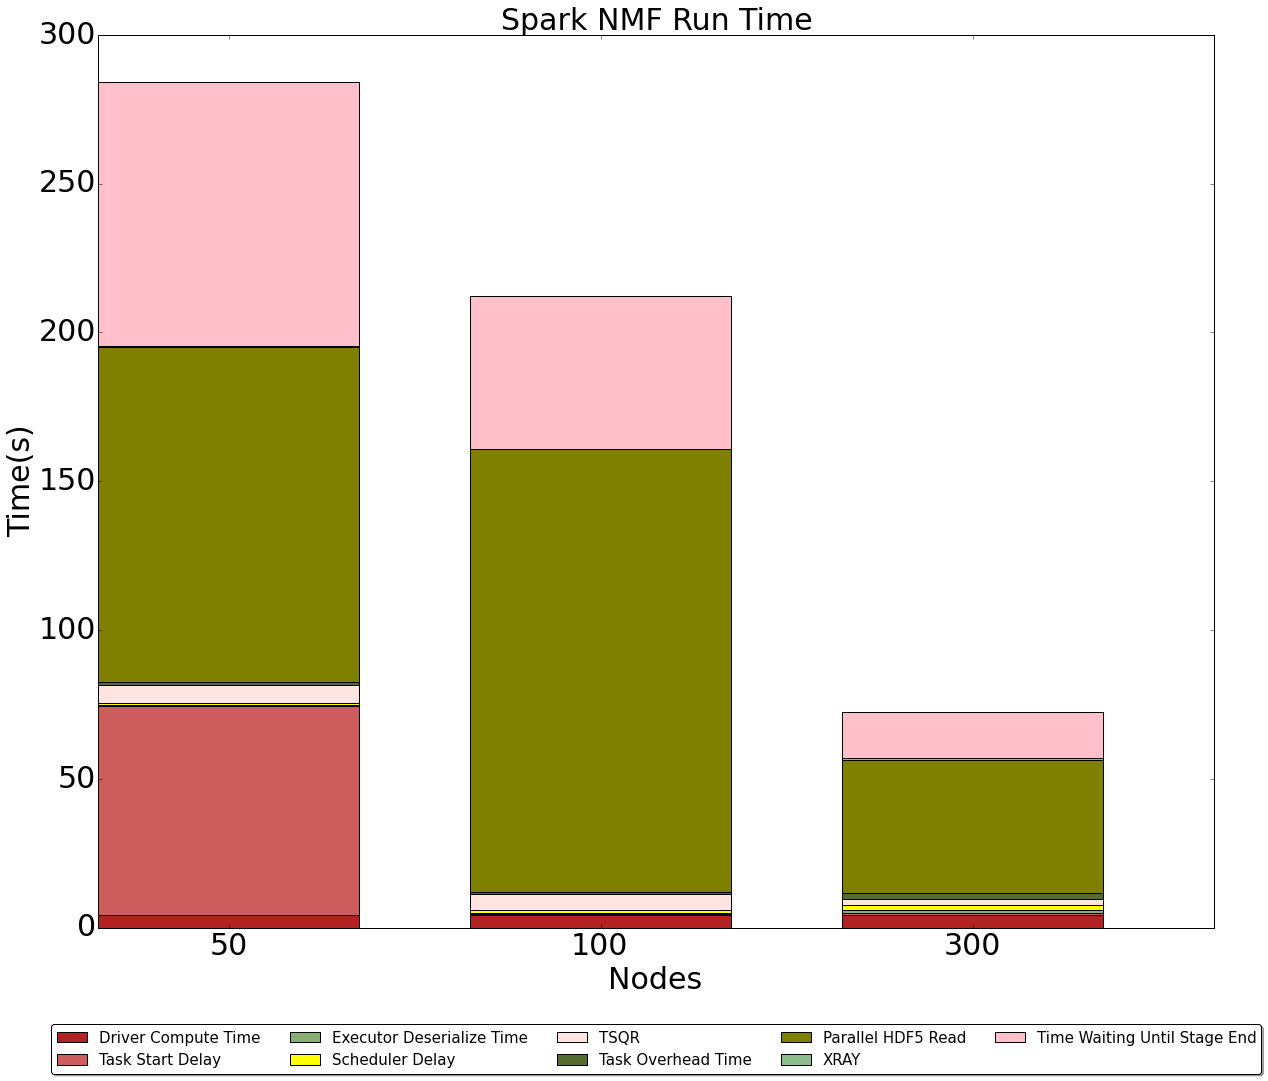

In [15]:
#plot
pt_n.plot_runtime_distribution() #makes plot with the colors you specified

* MPI

In [16]:

# get the mapping from bucket name to color name to keep consistency in mpi plots
nmf_color_dict = pt_n.get_colors_dict()
nmf_color_dict['Transpose'] = colors_list[-1] #hacky, but for some reason transpose isn't in the spark version

In [17]:
#here is mpi time breakdown (Aditya gave me these numbers)
nmf_mpi_brkdwn = {50: {'Parallel HDF5 Read': 57.99,
  'TSQR': 0.5,
  'Transpose': 7.48,
  'XRAY': 0.11},
 100: {'Parallel HDF5 Read': 39.79,
  'TSQR': 0.42,
  'Transpose': 3.75,
  'XRAY': 0.096},
 300: {'Parallel HDF5 Read': 32.13,
  'TSQR': 0.378,
  'Transpose': 1.29,
  'XRAY': 0.089}}

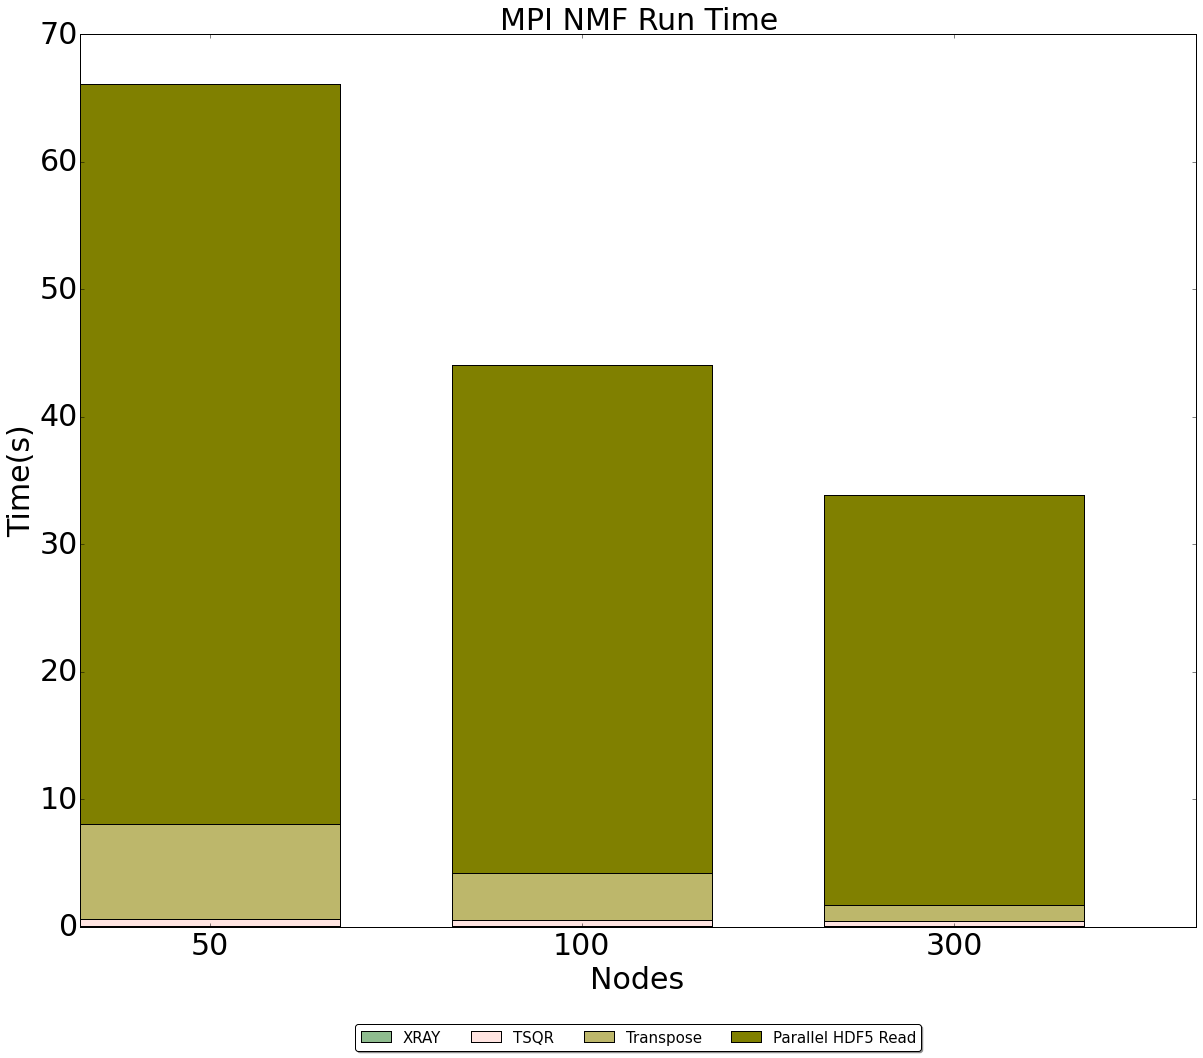

<module 'matplotlib.pyplot' from '/usr/common/software/python/matplotlib/1.4.3/lib/python2.7/site-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/pyplot.pyc'>

In [18]:
#make plotter object and use color_dict from spark plot
pnmf = RawValuesPlotter('nmf',colors_dict=nmf_color_dict) 
pnmf.plot_run_time_distribution(nmf_mpi_brkdwn)

##PCA Plots

* SPARK

In [19]:
pca_s2p_name_dict = \
{'collect at IndexedRowMatrix.scala': 'A*V Product',
 'collect at eofs.scala': 'Parallel HDF5 Read',
 'count at eofs.scala': 'Parallel HDF5 Read',
 'first at IndexedRowMatrix.scala': 'Parallel HDF5 Read',
 'parquetFile at eofs.scala': 'Parallel HDF5 Read',
 'reduce at IndexedRowMatrix.scala': 'Parallel HDF5 Read',
 'treeAggregate at eofs.scala': 'Gram Matrix-Vector Product',
 'treeReduce at eofs.scala': 'Gram Matrix-Vector Product',
 'zipWithIndex at eofs.scala': 'Parallel HDF5 Read'}

In [20]:
pca_driver_comp_labels = {"A*V Product": -2, "SVD A*V": -1} # last driver time is SVD A*V second to last is A*V product

In [21]:
pca_pds = [ParseLogs(sc,pca_dict[k] , 'pca', pca_s2p_name_dict, driver_comp_labels=pca_driver_comp_labels) for k in [100,300,500]]

In [22]:
keyed_pca_pds = dict(zip([100,300,500],pca_pds))

In [23]:
# custom color list here
colors_list = colors.cnames.keys()[50:90]

In [24]:
#use custom colors list
pt = SparkPlotter(keyed_pca_pds, colors_list=colors_list)

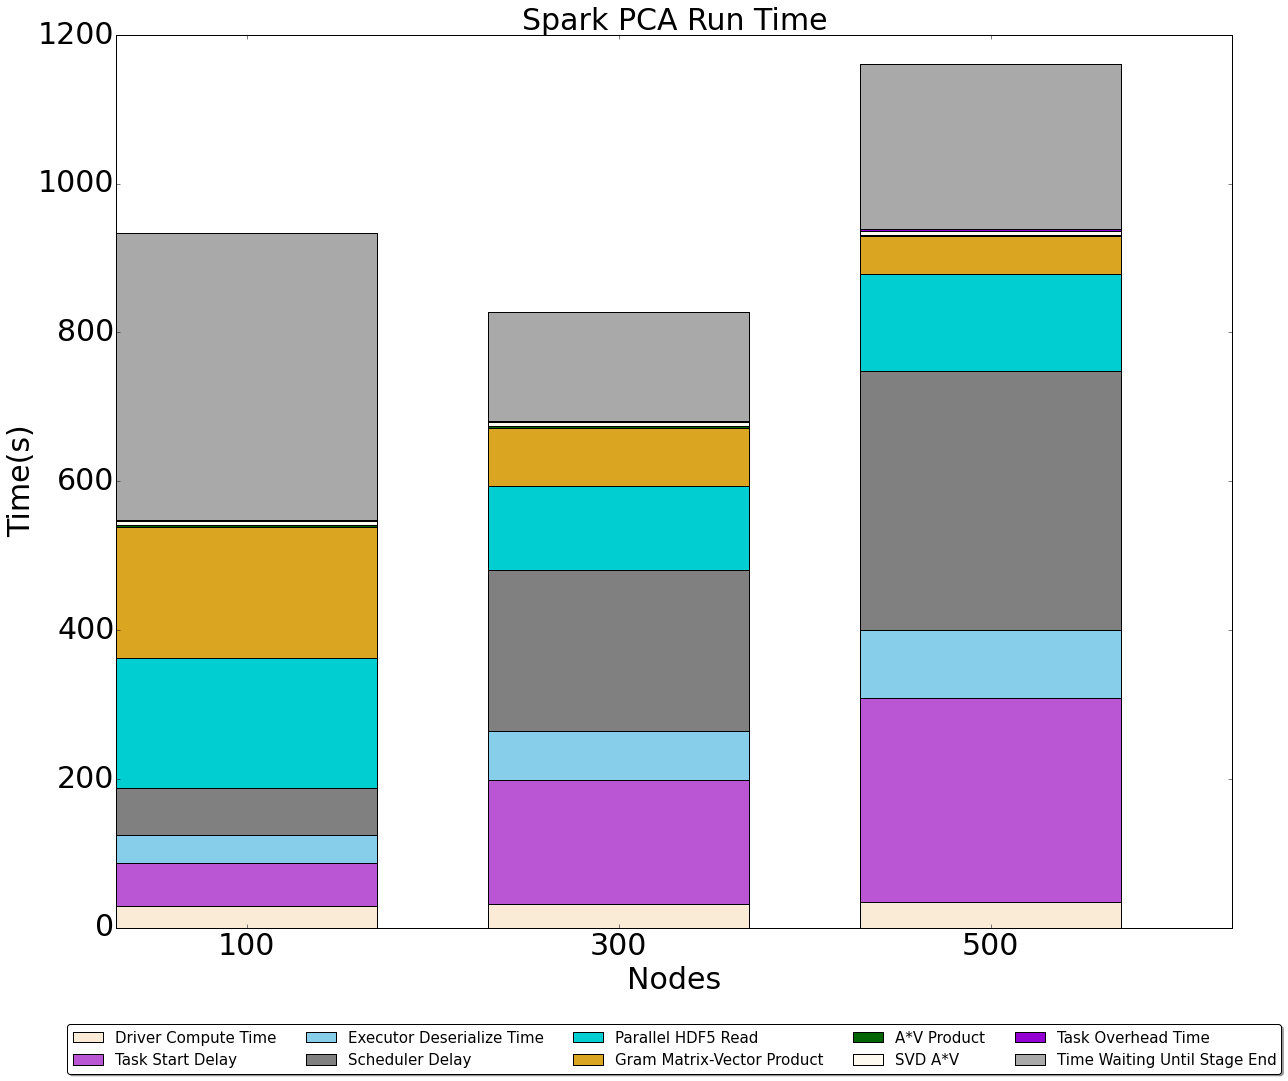

In [25]:
pt.plot_runtime_distribution(
    ordered_keys={'middle': ['Parallel HDF5 Read', 'Gram Matrix-Vector Product', 'A*V Product', 'SVD A*V']})

* MPI

In [26]:
#get colors dict from spark plot to keep consistency for buckets
pca_color_dict = pt.get_colors_dict()

In [27]:
#mpi time breakdown from Aditya
pca_mpi_brkdwn = {100: {'A*V Product': 1.33,
  'Gram Matrix-Vector Product': 45.86,
  'Parallel HDF5 Read': 33.75,
  'SVD A*V': 12.86},
 300: {'A*V Product': 2.77,
  'Gram Matrix-Vector Product': 13.29,
  'Parallel HDF5 Read': 31.83,
  'SVD A*V': 12.93},
 500: {'A*V Product': 5.33,
  'Gram Matrix-Vector Product': 7.96,
  'Parallel HDF5 Read': 29.68,
  'SVD A*V': 12.94}}

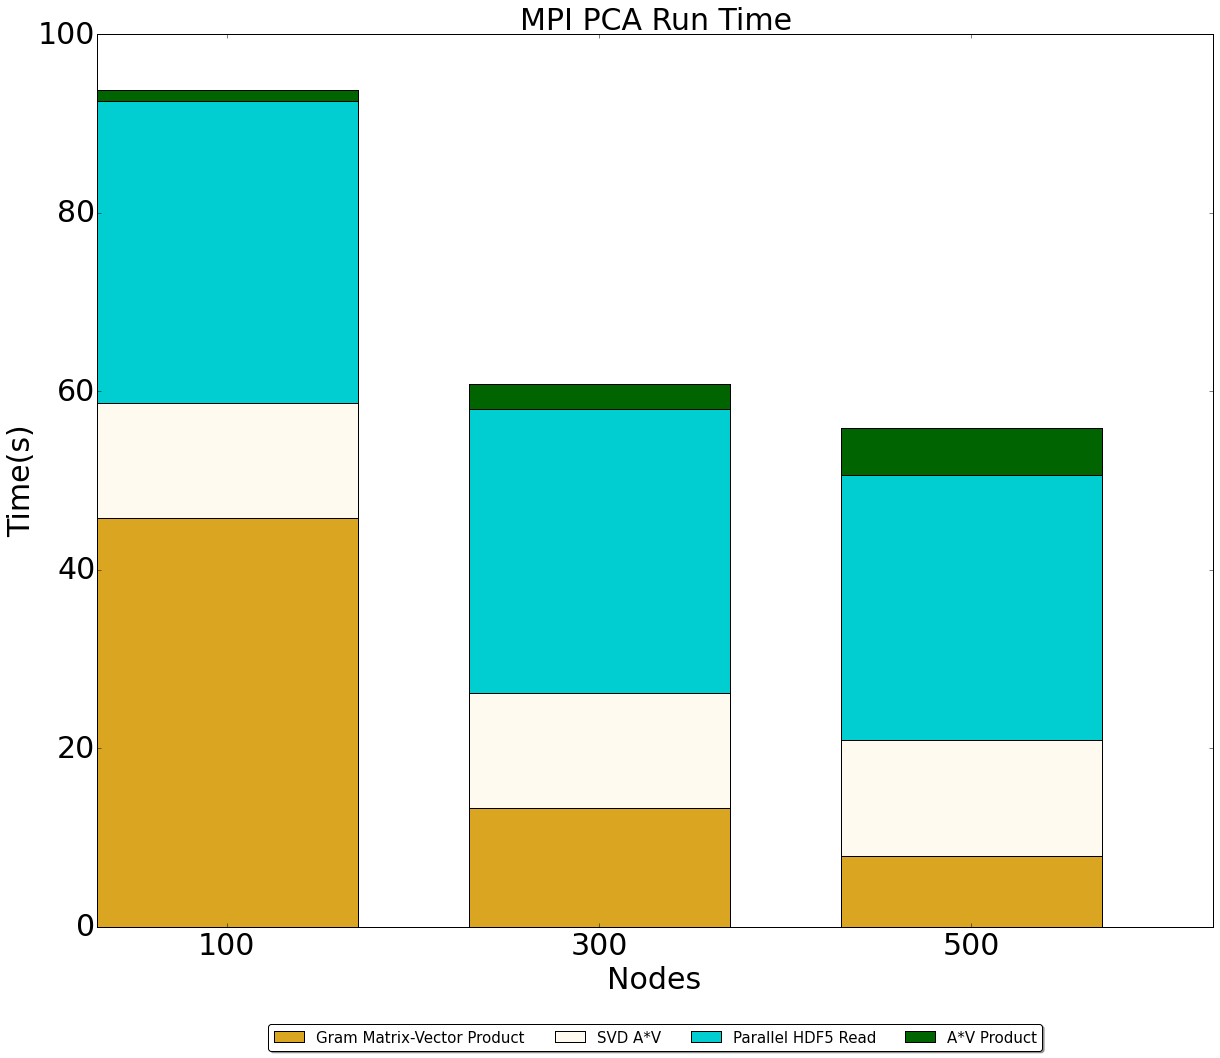

<module 'matplotlib.pyplot' from '/usr/common/software/python/matplotlib/1.4.3/lib/python2.7/site-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/pyplot.pyc'>

In [28]:
#plot mpi with colors_dict from spark
ppca = RawValuesPlotter('pca',colors_dict=pca_color_dict) 
ppca.plot_run_time_distribution(pca_mpi_brkdwn)

* CX Plots

In [29]:
cx_s2p_name_dict = {'treeAggregate at CX.scala': 'Gram Multiply', 'collect at IndexedRowMatrix.scala': 'Finalize/Collect', 'parquetFile at CX.scala': "Parallel Parquet Read", 
   'count at CX.scala':"Parallel Parquet Read"}

#cx_phase_names = ["Parallel Parquet Read", 'Gram Multiply', 'Finalize/Collect', 'SVD']

In [30]:
keyed_cx_pds = {k:ParseLogs(sc,cx_dict[k] , 'cx', cx_s2p_name_dict, driver_comp_labels={'Slow SVD': -1} ) for k in cx_dict.keys()}

In [31]:
# custom color list here
colors_list = colors.cnames.keys()[90:120]
pt_c = SparkPlotter(keyed_cx_pds, colors_list=colors_list)

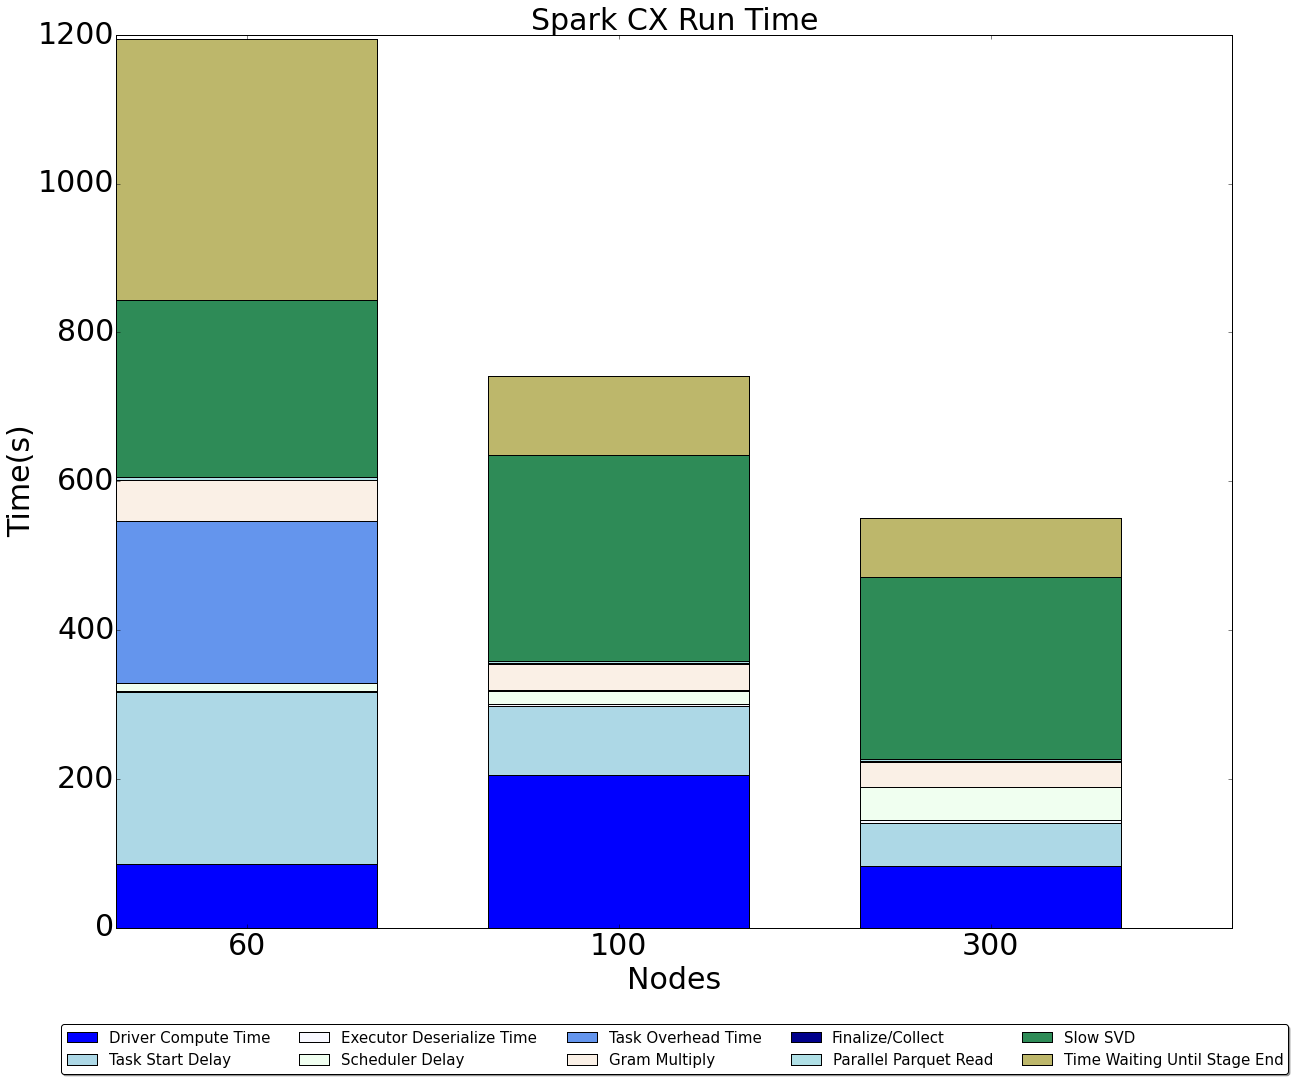

In [32]:
pt_c.plot_runtime_distribution()

#Special Plot For Hero Run

In [9]:
pca_s2p_name_dict = \
{'collect at IndexedRowMatrix.scala': 'A*V Product',
 'collect at eofs.scala': 'Parallel HDF5 Read',
 'count at eofs.scala': 'Parallel HDF5 Read',
 'first at IndexedRowMatrix.scala': 'Parallel HDF5 Read',
 'parquetFile at eofs.scala': 'Parallel HDF5 Read',
 'reduce at IndexedRowMatrix.scala': 'Parallel HDF5 Read',
 'treeAggregate at eofs.scala': 'Gram Matrix-Vector Product',
 'treeReduce at eofs.scala': 'Gram Matrix-Vector Product',
 'zipWithIndex at eofs.scala': 'Parallel HDF5 Read'}

In [10]:
pca_driver_comp_labels = {"A*V Product": -2, "SVD A*V": -1} # last driver time is SVD A*V second to last is A*V product

In [11]:
#This one takes a while
pca_pds = {1600:ParseLogs(sc,pca_dict[k] , 'pca', pca_s2p_name_dict,
                     driver_comp_labels=pca_driver_comp_labels) for k in [1600]}


In [12]:
mpi_times= {1600:{'Parallel HDF5 Read': 69.44,
'Gram Matrix-Vector Product': 20.12,
'A*V Product': 43.64,
'SVD A*V': 25.96}}

In [17]:
# custom color list here
colors_list = colors.cnames.keys()[75:101]
hero_plt = SparkPlotter(pca_pds, colors_list=colors_list)
hero_mpi_plt = RawValuesPlotter('mpi_hero_pca')

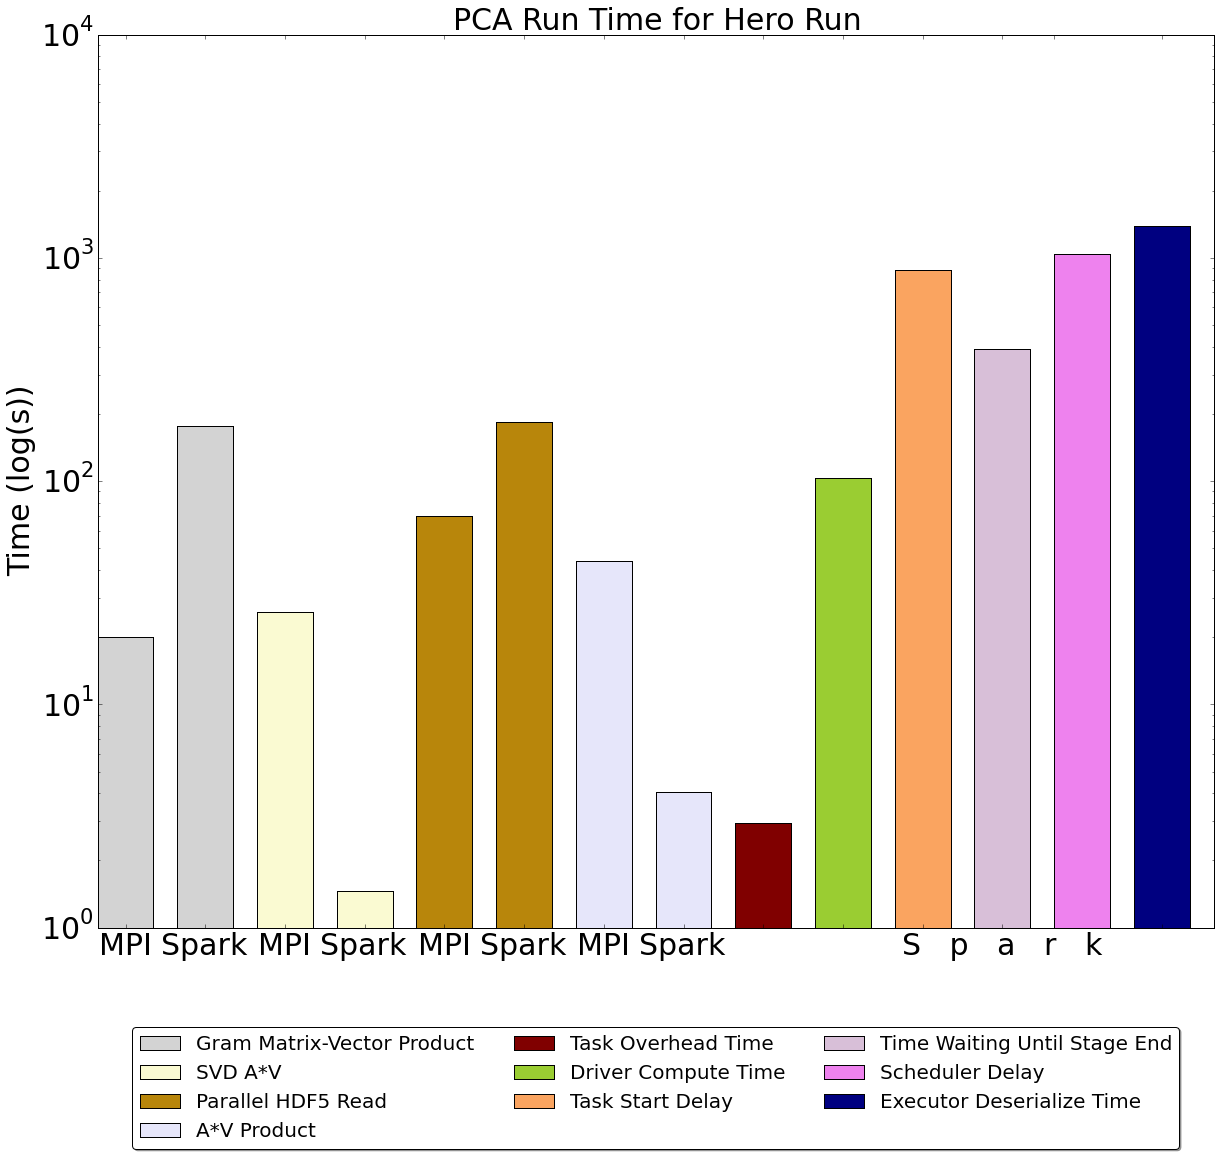

In [19]:
plot_hero(hero_plt, hero_mpi_plt, mpi_times)

#Stage by Stage, Executor by Executor Spark Plots

In [15]:
pd = pca_pds[0]

In [37]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
plt.rcParams['figure.figsize'] = (40.0, 32.0)

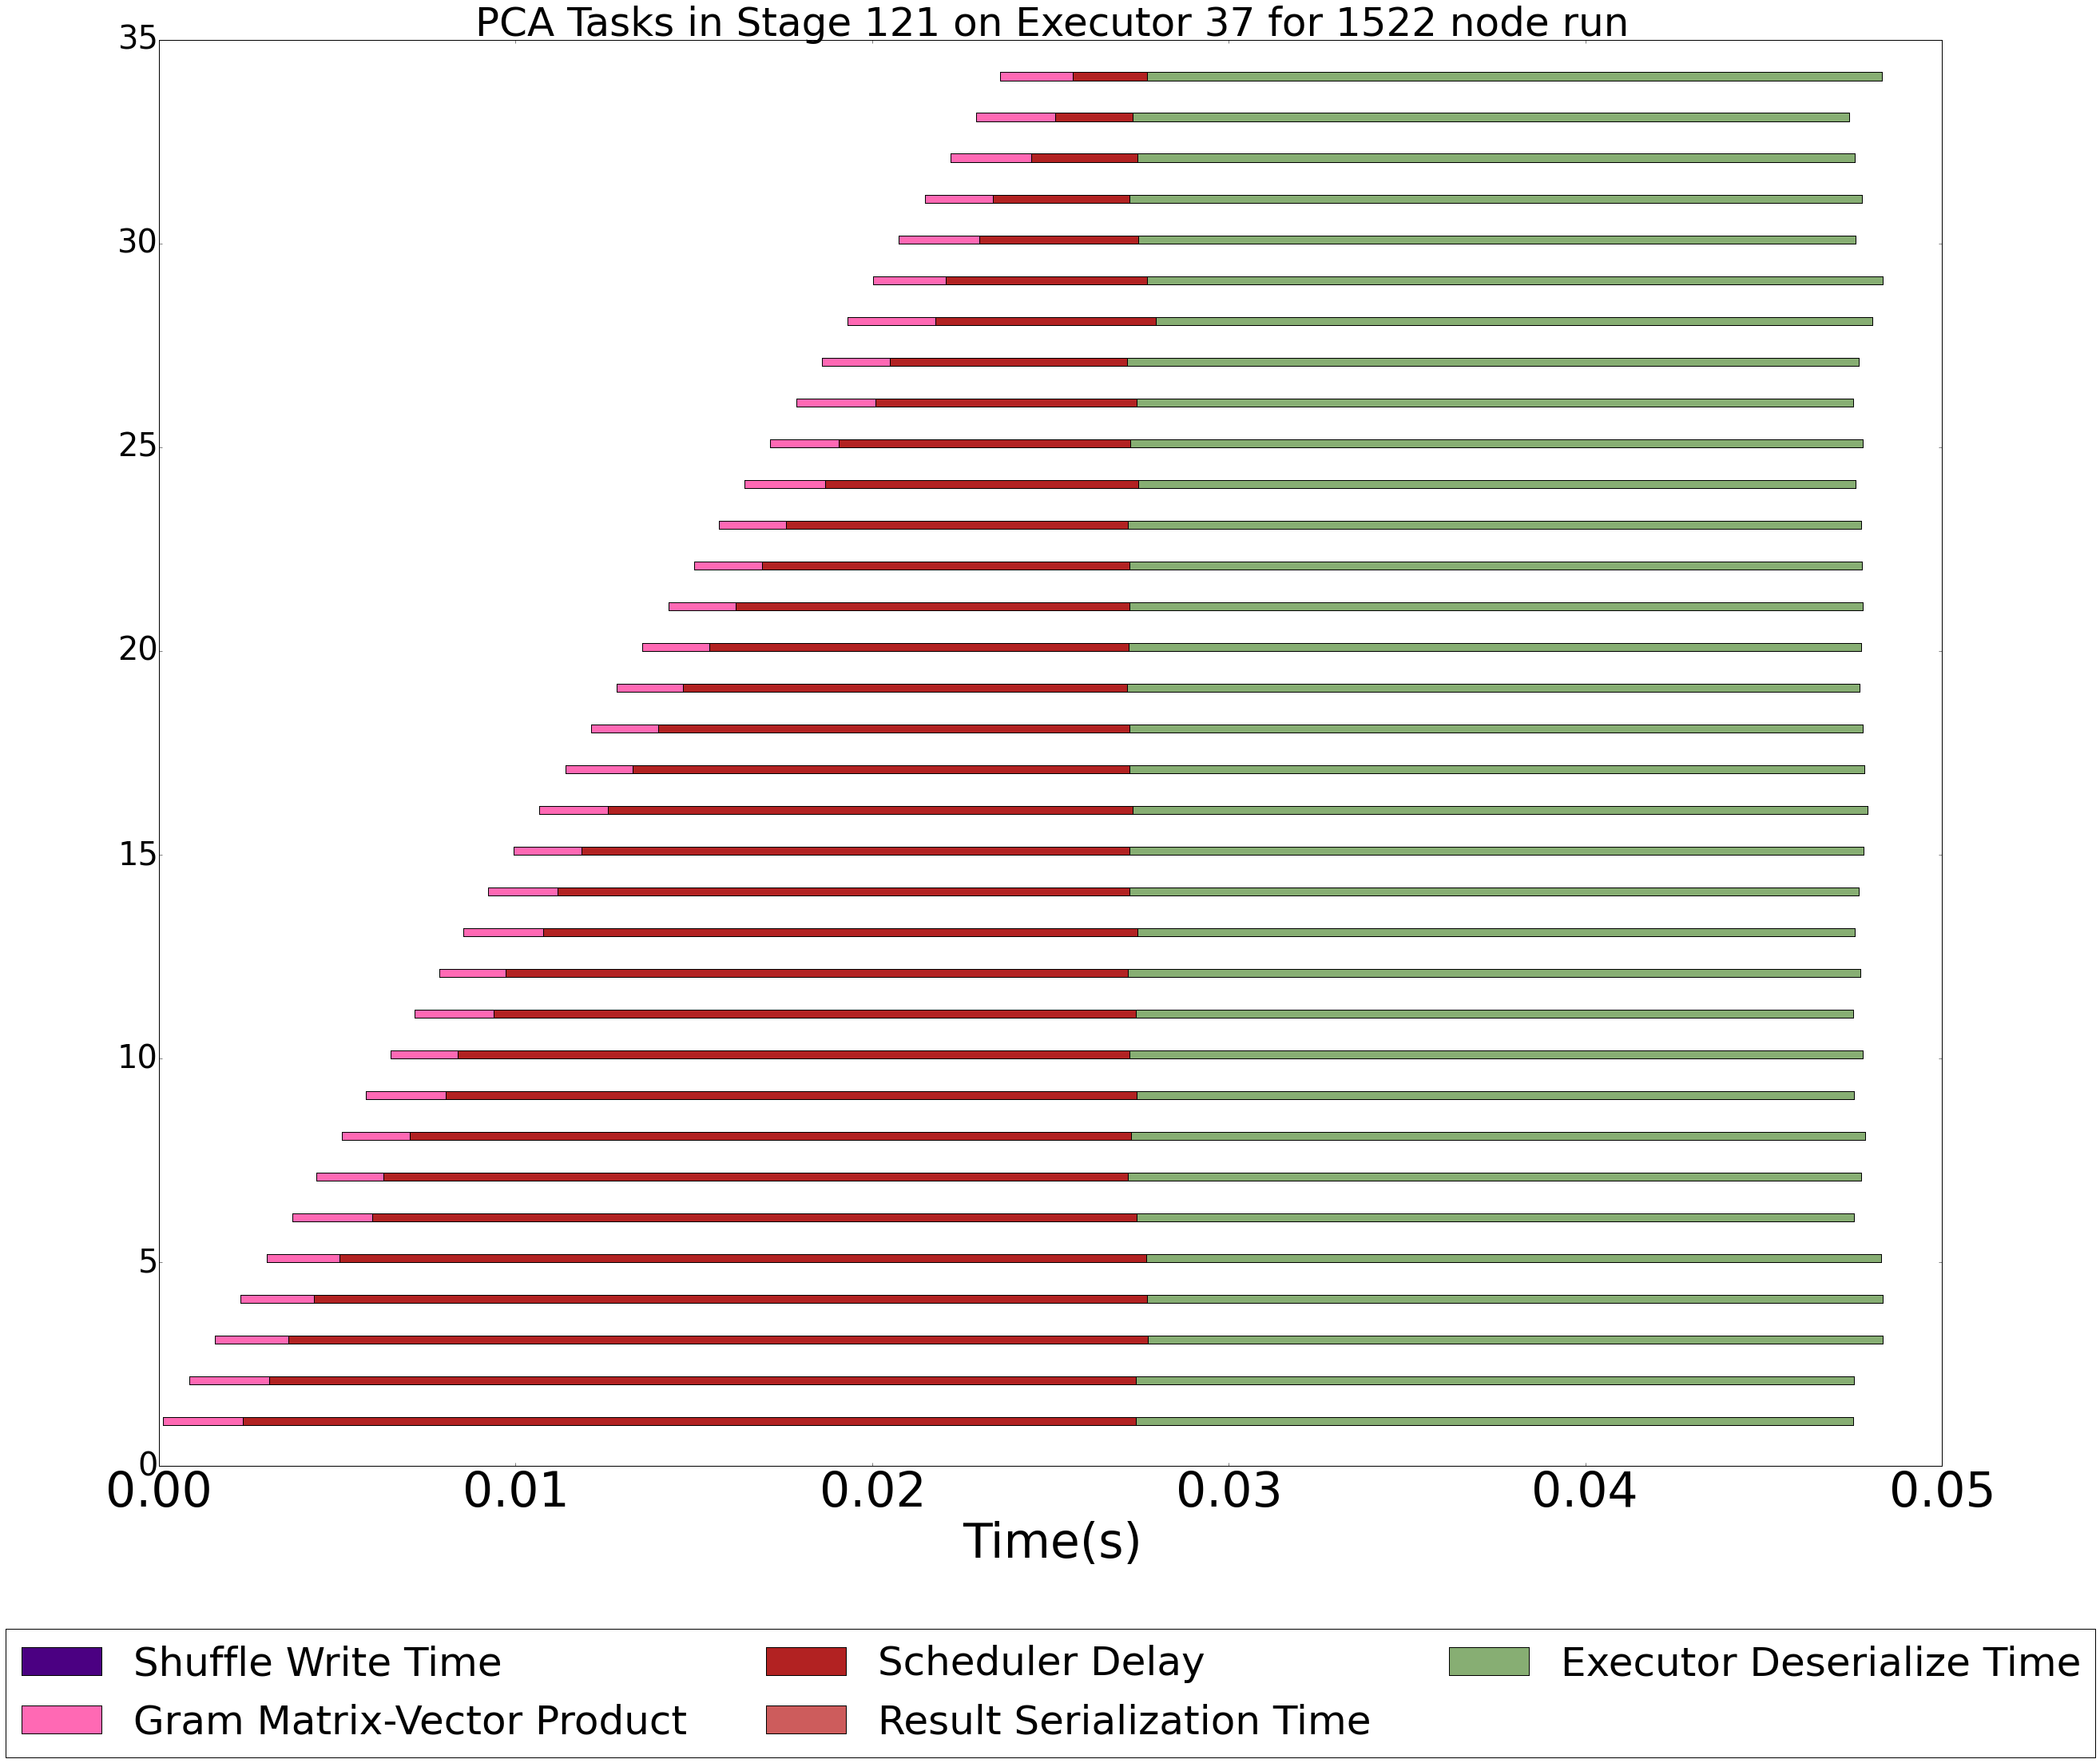

In [31]:
ex_stage_tasks1 = pd.stage_and_exec_keyed_task_info.filter(lambda ((stage,ex), d):stage in [121] and ex in [37])
ex_stage_tasks2 = pd.stage_and_exec_keyed_task_info.filter(lambda ((stage,ex), d): stage in [8] and ex in [37])
t_dict1,t_dict2 = (ex_stage_tasks1.map(lambda (i,v): v).collect(), ex_stage_tasks2.map(lambda (i,v): v).collect())
t_dict1.sort(lambda v1,v2: 1 if v1['Task Start Delay'] > v2['Task Start Delay'] else -1)
t_dict2.sort(lambda v1,v2: 1 if v1['Task Start Delay'] > v2['Task Start Delay'] else -1)
rds = t_dict1
left = len(rds)*[0]
bars = []
colors_ = colors.cnames.keys()
offset = 47
offset2=105
#patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(len(rds) + 1)
height = 0.2
#stage_barrier = 0.2
stage_begins = [0]
label_dict = {}


    
for m,rd in enumerate(rds):
        for i,k in enumerate(rd.keys()):
            if k not in rd:

                continue
            cur = rd[k] / 1000.
            if k not in label_dict:

                label = k
                label_dict[label] = 0
            else:
                label = None 
#             if k in color_key_dict:
#                 color = colors_[i]#color_key_dict['pca'][k]
#             elif k in color_key_dict:
#                 color= colors_[i] #colors_dict[k]
#             else:
            color = colors_[i] #colors_[offset+i]
            ecolor = 'k'
            if k == "Time Waiting Until Stage End" or k == "JVM GC Time":
                continue
            #cur_values = np.asarray([c_mpl[(stage,execu)][k] / 1000. for c_mpl in rds] )
            if  k != 'Task Start Delay':
                bar = ax1.barh(ind[m+1], cur,
                                height=height,color=color, left=left[m],
                                 ecolor=ecolor, label=label)

            left[m] = left[m] + cur
    #print left




ax1.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   ncol=3, prop={'size': 50})







ax1.set_xlabel('Time(s)', fontdict={'size':60})
plt.yticks(size=40)
plt.title("%s Tasks in Stage %s on Executor %s for %i node run"% (pd.algo.upper(), 121, 37, pd.num_execs), fontdict={'size': 50})
plt.xticks(size=60)
plt.show()

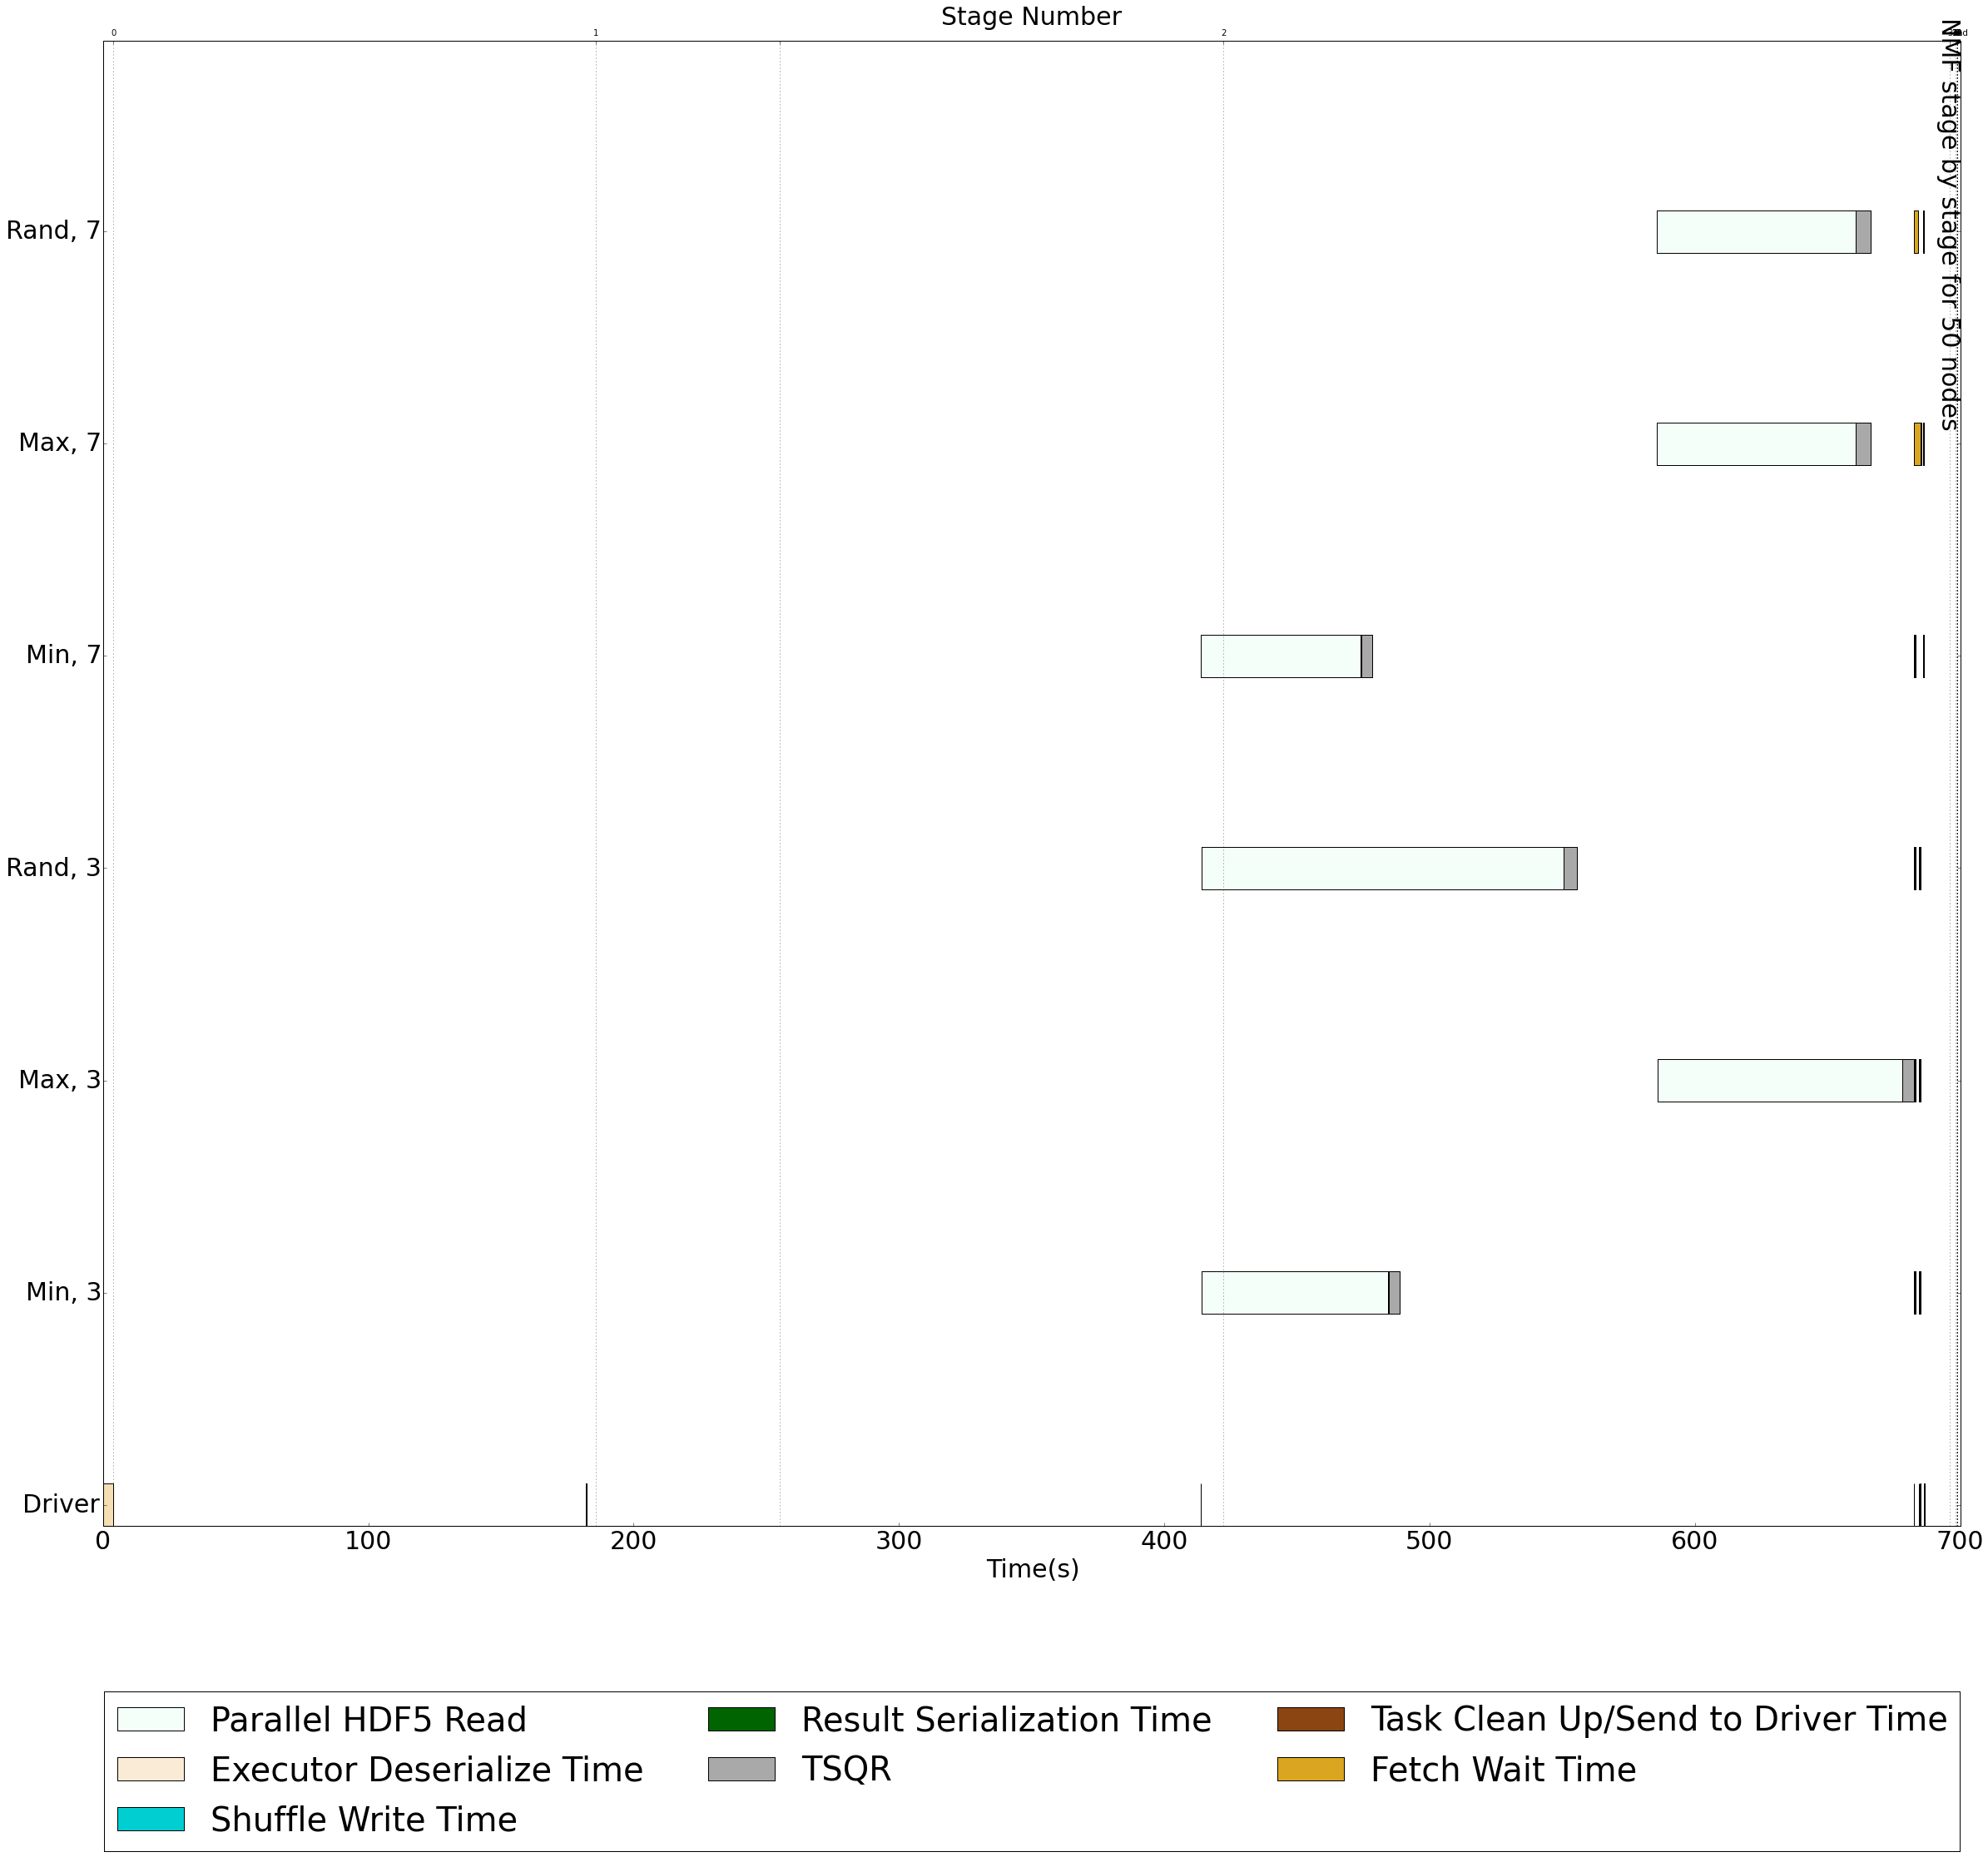

In [48]:
minr, maxr,randr = [pd.get_summary_tasks_for_each_executor(f, 'Time To Finish From Stage Start') 
              for f in ['min', 'max','rand']]
min1, max1, rand1 = [da_rdd.filter(lambda ((stage,execu), task): execu == 3).collectAsMap() for da_rdd in [minr, maxr, randr]]
min2, max2, rand2 = [da_rdd.filter(lambda ((stage,execu), task): execu == 7).collectAsMap() for da_rdd in [minr, maxr, randr]]
rds = (min1,max1,rand1,min2,max2,rand2)
left = tuple(len(rds)*[0])
bars = []
colors_ = colors.cnames.keys()
offset = 47
offset2=105
#patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(len(rds) + 1)
height = 0.2
#stage_barrier = 0.2
stage_begins = [0]
label_dict = {}

for stage,time in stage_times.iteritems():
    #make driver bar
    driv_comp_time = pd.driver_comp_dict[stage-1]/1000.
    cur_values = np.asarray( len(left)*[driv_comp_time])
    bar = ax1.barh((0), cur_values[0],
                            height=height,color=colors_[offset2+9], left=left[0],
                             ecolor='k')
    
    left = left + cur_values
    stage_begins.append(left[0])
    #print stage, len(stage_begins)

    
    for m,rd in enumerate(rds):
        execu = rd.keys()[0][1]
        if (stage,execu) not in rd:
            left[m] = left[m] + stage_times[stage] / 1000.
            #print stage,execu
            continue
        for i,k in enumerate(ordered_keys):
       

    
            cur_rd = rd[(stage,execu)]
            if k not in cur_rd:

                continue
            cur = cur_rd[k] / 1000.
            if k not in label_dict:

                label = k
                label_dict[label] = 0
            else:
                label = None 
            color=colors_[i+offset]
            ecolor = 'k'

            #cur_values = np.asarray([c_mpl[(stage,execu)][k] / 1000. for c_mpl in rds] )
            if k != "Time Waiting Until Stage End" and k != 'Task Start Delay':
                bar = ax1.barh(ind[m+1], cur,
                                height=height,color=color, left=left[m],
                                 ecolor=ecolor, label=label)

            left[m] = left[m] + cur
    #print left


cur_values = (pd.driver_comp_dict[stage] / 1000.)

bar = ax1.barh((0), cur_values,
                        height=height,color=colors_[offset2+9], left=left[0],
                         ecolor='k')

stage_begins.append(left[0])

ax1.legend()
ax1.legend( loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   ncol=3, prop={'size': 40})

ax2 = ax1.twiny()


stage_begins.append(250)
ax2.xaxis.set_ticks(stage_begins)


labels = [item.get_text() for item in ax2.get_xticklabels()]
#ax2.set_xticks?
labels[0] = ''
labels[1:len(stage_begins)] = list(range(len(stage_begins)))
labels[-2] = ''
labels[-3] = 'end'
ax2.set_xticklabels(labels)
ax2.grid(True)
ax2.set_xlabel('Stage Number', fontdict={'size':30})
ax1.set_xlabel('Time(s)', fontdict={'size':30})
plt.yticks(ind + height/2., ('Driver','Min, 3', 'Max, 3','Rand, 3', 'Min, 7', 'Max, 7', 'Rand, 7'))
plt.title("%s stage by stage for %i nodes"% (pd.algo.upper(), pd.num_execs), rotation=-90, loc='right', fontdict={'size': 30})
ax1.tick_params( which='major', labelsize=30)
ax2.tick_params(axis=ax1, which='minor', labelsize=30)
plt.show()

#Plot Summary Using Max/Min/Median **Bucket** (Task Category) in each Stage

In [10]:


minb, maxb, medianb, meanb = [pd.get_summary_buckets_for_mpl(f) for
                              f in ['min', 'max', 'median', 'mean']]
bottom = (0,0,0, 0)
bars = []
colors_ = colors.cnames.keys()
offset = 41
patterns = ('-', '+', 'x', '\\', '*', '.')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ind = np.arange(4)
width = 0.2
for i,k in enumerate(ordered_keys):
    cur_values = np.asarray([c_mpl[k] / 1000. for c_mpl in [minb, medianb, meanb, maxb]])
    bar = ax1.bar(ind, cur_values,
                        width=width,color=colors_[i+offset], bottom=bottom,
                         ecolor='k')

    bottom = bottom + cur_values

ax1.legend(ordered_keys, loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=True, ncol=5, prop={'size': 10})
plt.ylabel('Time(s)')
plt.xticks(ind + width/2., ('Min', 'Median','Mean', 'Max'))
plt.title("%s at %s buckets"% (algo_name, event_log.split('benchmarks/')[1]))
plt.show()
summary_buckets= {pd.num_execs: pd.get_summary_buckets_for_mpl('max') for pd in pds}
bucket_sums = {num: sum([v for k,v in val.iteritems() if k[1] == "Task Start Delay"]) for num,val in summary_buckets.iteritems()}

bucket_maxes = {num: max([v for k,v in val.iteritems() if k[1] == "Task Start Delay"]) for num,val in summary_buckets.iteritems()}
buckets = {num: [v for k,v in val.iteritems() if k[1] == "Task Start Delay"] for num,val in summary_buckets.iteritems()}


#Box and Whisker Plot For Task Compute End Stuff and Task Start Delay

Gram Matrix-Vector Product


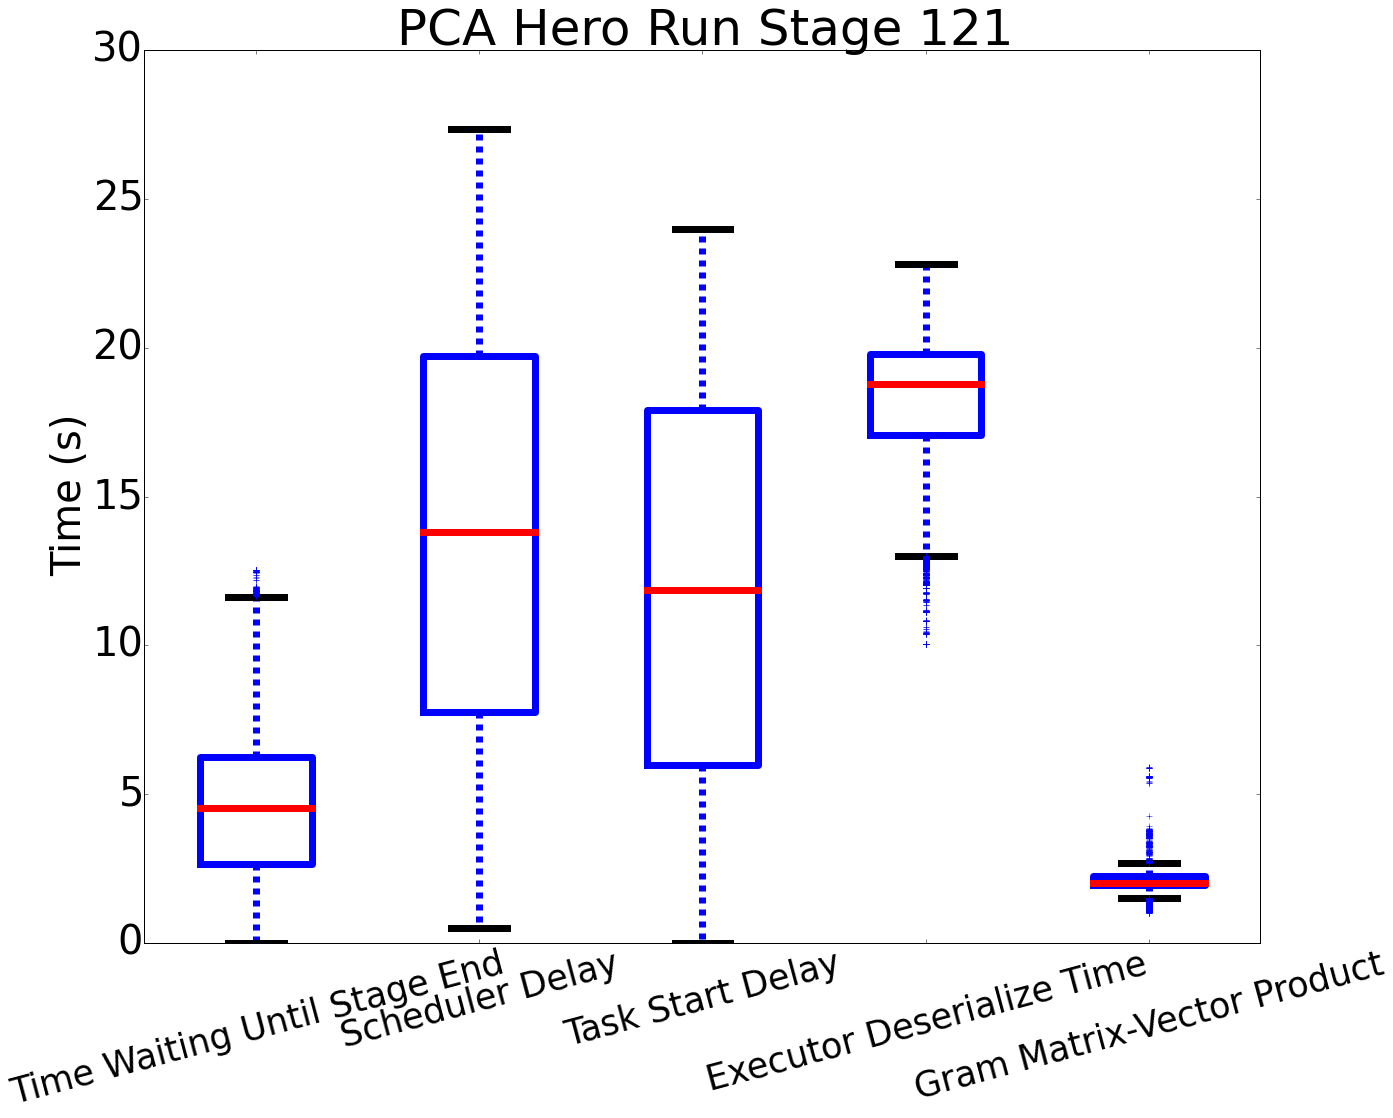

In [30]:
whisker_buckets=['Time Waiting Until Stage End', "Scheduler Delay", "Task Start Delay",
                 "Executor Deserialize Time","Gram Matrix-Vector Product", ]
task_dicts = {key: pd.stage_keyed_task_info.filter(lambda (stage,d): stage==121).filter(lambda (i,v): key in v).map(lambda (i,v): (i,v[key] / 1000.))\
.groupByKey().map(lambda (i,v): (i,list(v)))\
.collectAsMap() for key in whisker_buckets }
stage=121
plt.rcParams['figure.figsize'] = (20.0, 16.0)
plt.clf()
inds = np.arange(len(whisker_buckets)) + 1
#for i,k in enumerate(whisker_buckets):
print k
#plt.figure(i)
#if task_dicts[k] == {}:
#    continue
vals = [task_dicts[k][121] for k in whisker_buckets]

box=plt.boxplot(vals)

bplot_keys = ['boxes', 'whiskers', 'caps','fliers', 'medians']
for key in bplot_keys:
    for value in box[key]:
        value.set(linewidth=7)
plt.xticks(inds,whisker_buckets, fontsize=35, rotation=15)
plt.yticks(fontsize=40)
plt.ylabel('Time (s)', fontsize=40)
plt.title('PCA Hero Run Stage %s' % (stage), fontsize=50)
plt.show()